## 1. Question Posed

As we all konw, Titanic event is one of the most famous disasters throughout the world. More than 1500 people total died, including passengers and crew, and there were an estimated 2224 people aboard the ship.  I'm curious about the survival rate patterns over age, sex and social-economic statu, e.g. 
- During all the rescues, was the priority given to the elderly and children? What about the females?
- Were people with low social-economic status treated equally during the rescues?

Thus the follwing questions are my concern:

- **What variables are related to survival rate?**

    - What gender has a better survival rate?
    - Among the dead, how old is the oldest person？ And the youngest?
    - What are the survival rate patterns over age?
    - Are those passengers having higher ticket class likely to survive?
    - How does the interpersonal relationships (*siblings/spouses* and *parents/children*) affect the survival rate?
   
   
- **What patterns can I find in the ticket class?**
    - 

https://www.kaggle.com/c/titanic/data

***
## 2. Handling the missing/NA values
Before investigating the survived rata pattern over age, we need to check the **missing/NA values** related to 'Age' and fix them.

In [272]:
# First of all, We need to load datas from the csv file.
# Import required modules
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

# load the csv file
data = pd.read_csv('titanic-data.csv')
data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [273]:
# Identify the fields containing missing/NA values and the amount
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [274]:
data_by_PclassSex = data.groupby(['Pclass', 'Sex']).mean()['Age']
data_by_PclassSex

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [275]:
# Create a empty DataFrame to contenate multiple fixed DataFrame
fixed_age = pd.DataFrame(columns=['Age'])

# Replace the NA values of Age with the mean age by categories
for pclass, sex in data_by_PclassSex.index:
    filtered_age = data[(data['Pclass']==pclass) & (data['Sex']==sex)]['Age']
    filtered_age = filtered_age.fillna(data_by_PclassSex.loc[pclass, sex])
    fixed_age = pd.concat([fixed_age, filtered_age]).astype('float64')

# Assign the fixed column to the origin 
# and see the first five rows of the dataset
data['Age'] = fixed_age
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---
## 3. Exploring Data and Visualization

#### 3.1 Age, Sex, Pclass and Survival Rate

In [276]:
# Set the fixed bins
bin_values = np.arange(start=0, stop=90, step=10)
bin_values

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80])

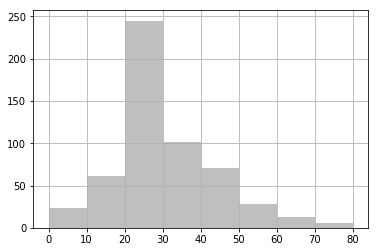

In [516]:
# Select the data of the dead
dead = data[data['Survived']==0]

# Plot the distribution of the dead's age by given bins
dead['Age'].hist(color='Grey', alpha=0.5, bins=bin_values)
plt.show()

The dead are mainly young people, especially those aged 20-30. The vast majority of the dead are less than 50 years old.

In [278]:
# Get the descriptive statistics for the age of the dead
dead['Age'].describe()

count    549.000000
mean      30.025651
std       12.769635
min        1.000000
25%       22.000000
50%       26.507589
75%       37.000000
max       74.000000
Name: Age, dtype: float64

The average age of the dead is about 30, and 75% of them aren't more than 37 years old. The oldest deceased is as much as 74 years old, and the youngest is only 1 years old. We may go through their profiles by the follwing way.

In [279]:
# Get the profile of the youngest deceased
dead.loc[dead['Age'].argmin()]

PassengerId                             165
Survived                                  0
Pclass                                    3
Name           Panula, Master. Eino Viljami
Sex                                    male
Age                                       1
SibSp                                     4
Parch                                     1
Ticket                              3101295
Fare                                39.6875
Cabin                                   NaN
Embarked                                  S
Name: 164, dtype: object

We can see the youngest deceased is a baby boy with the lowest ticket class.

In [280]:
# Get the profile of the oldest deceased
dead.loc[dead['Age'].argmax()]

PassengerId                    852
Survived                         0
Pclass                           3
Name           Svensson, Mr. Johan
Sex                           male
Age                             74
SibSp                            0
Parch                            0
Ticket                      347060
Fare                         7.775
Cabin                          NaN
Embarked                         S
Name: 851, dtype: object

The oldest deceased is a old man and he also has the lowest class of ticket.

In [281]:
# Define a function to group the data to see the distribution of survivors
# and get the survival rate of each group
def group_survivalDistr(dataframe_name, field_name):
    grouped_survived = dataframe_name.groupby([field_name, 'Survived']).size().unstack()
    grouped_survived.fillna(0, inplace=True)
    grouped_survived['proption_survived'] = (grouped_survived[1] / 
                                             (grouped_survived[0] + 
                                              grouped_survived[1])).round(3)
    return grouped_survived

In [282]:
# Cut the age by the given bins and add ageBinned column
data['ageBinned'] = pd.cut(data['Age'], bins=bin_values)

# Apply the survival distribution function for ageBinned
survivalRate_by_ageBinned = group_survivalDistr(data, 'ageBinned')
survivalRate_by_ageBinned

Survived,0,1,proption_survived
ageBinned,,,
"(0, 10]",26,38,0.594
"(10, 20]",71,44,0.383
"(20, 30]",248,120,0.326
"(30, 40]",93,80,0.462
"(40, 50]",69,38,0.355
"(50, 60]",25,17,0.405
"(60, 70]",13,4,0.235
"(70, 80]",4,1,0.200


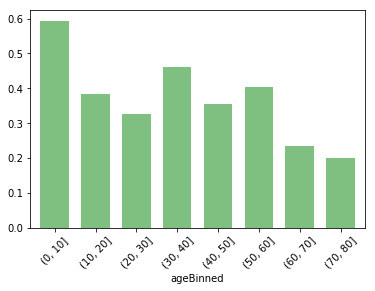

In [522]:
# Plot the survival rate of each group
survivalRate_by_ageBinned['proption_survived'].plot.bar(color='g', rot=45, alpha=0.5, width=0.7)
plt.show()

**The first bar of the two charts above** shows the suvival rate of infant children is nearly 60%, higher than other groups.

I also want to konw what **gender** has a better survival rate. Does the conclusion apply equally to the children?

In [286]:
# Get the survival distributions of differrent genders
overall_sex_survivalDistr = group_survivalDistr(data, 'Sex')
overall_sex_survivalDistr

Survived,0,1,proption_survived
Sex,,,
female,81,233,0.742
male,468,109,0.189


The survival rate of female is more than 4 times that of male. It seems that **women** have acquired enough respects in rescues.

In [407]:
# Select the data of the children with the highest survival rate
children = data[data['Age'] <= 10]

# Among the children, get the survival distributions of differrent genders
children_sex_survivalDistr = group_survivalDistr(children, 'Sex')
children_sex_survivalDistr

Survived,0,1,proption_survived
Sex,,,
female,12,19,0.613
male,14,19,0.576


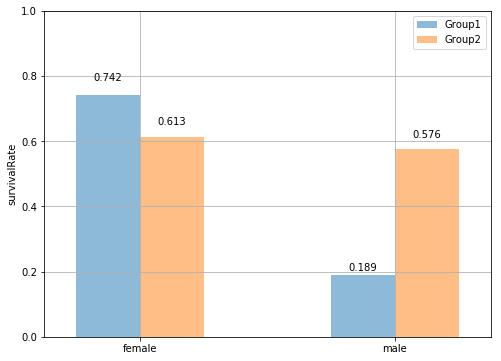

In [515]:
fig, ax = plt.subplots(figsize=[8, 6])

N = 2
ind = np.arange(N)
width = 0.25

rects1 = plt.bar(ind, 
                 overall_sex_survivalDistr['proption_survived'], 
                 width, 
                 alpha=0.5, 
                 label=overall_sex_survivalDistr.index[0])

rects2 = plt.bar(ind + width, 
                 children_sex_survivalDistr['proption_survived'], 
                 width, 
                 alpha=0.5, 
                 label=overall_sex_survivalDistr.index[1])

ax.set_ylabel('survivalRate')
ax.set_xticks([p + width / 2 for p in ind])
ax.set_xticklabels(overall_sex_survivalDistr.index)

plt.xlim(-width, 1 + width * 2)
plt.ylim(0, 1)
plt.legend(['Group1', 'Group2'])
plt.grid()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, str(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [532]:
overall_sex_survivalDistr.name = 'overall_sex_survivalDistr'
children_sex_survivalDistr.name = 'children_sex_survivalDistr'

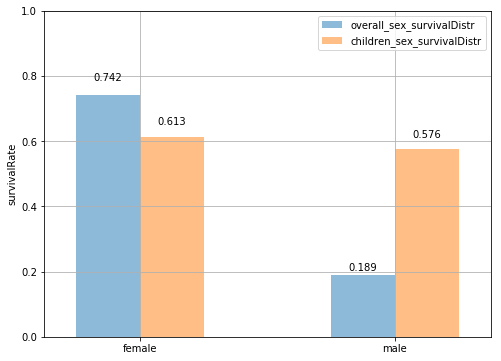

In [534]:
fig, ax = plt.subplots(figsize=[8, 6])

N = 2
ind = np.arange(N)
width = 0.25

rects1 = plt.bar(ind, 
                 overall_sex_survivalDistr['proption_survived'], 
                 width, 
                 alpha=.5, 
                 label=overall_sex_survivalDistr.index[0])

rects2 = plt.bar(ind + width, 
                 children_sex_survivalDistr['proption_survived'], 
                 width, 
                 alpha=0.5, 
                 label=overall_sex_survivalDistr.index[1])

ax.set_ylabel('survivalRate')
ax.set_xticks([p + width / 2 for p in pos])
ax.set_xticklabels(overall_sex_survivalDistr.index)

plt.xlim(-width, 1 + width*2)
plt.ylim(0, 1)
plt.legend([overall_sex_survivalDistr.name, children_sex_survivalDistr.name])
plt.grid()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, str(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

However, the preferential treatment for females doesn't aplly to children. Among the children, the survival rates of boys and girls are almost the same. Interestingly, the girls' survival rate is lower than the overall survival rate of females.

Still a small number of women are excluded from the list of survivors. So what is the common characteristic of those **servived women**? Does the characteristic include the **ticket class**, which represents the social-economic status?

Before this, the the overall survival distributions of passengers with different social-economic status will be investigated.

In [535]:
group_survival_distribution(data, 'Pclass')

Survived,0,1,proption_survived
Pclass,,,
1,80,136,0.630
2,97,87,0.473
3,372,119,0.242


The survival rate of the passengers with ticket class 2 is almost twice that of those people with ticket class 3. Further more, passengers with ticket class 1, the highest class, are nearly 63% chance of survivors. That means **the higher ticket class a passenger has, the more likely it is to be saved from the disaster**, which we call it **_law of ticket class and survival rate_** for the time being. Next, we'll inspect the applicability of the law. 

In [536]:
females = data[data['Sex']=='female']

group_survival_distribution(females, 'Pclass')

Survived,0,1,proption_survived
Pclass,,,
1,3,91,0.968
2,6,70,0.921
3,72,72,0.500


The survival rate of women with first two ticket classes are more than 90%, while only half of women with the last ticket class can be rescued. Although women have got proper care in rescues, the degree of care for women with different social-economic status are not the same. What about the care for children with different ticket classes?

In [ ]:
group_survival_distribution(children, 'Pclass')

The sample with ticket class 1 is too small to be considered. All of the children with ticket class 2 are saved, while the survival rate of children with ticket class 3 is only less than half. That is to say, the **_law of ticket class and survival rate_** can apply to women and children.

#### 3.2 Other Factors and Survival Rate

In [ ]:
data['Embarked'].dropna(inplace=True)

group_survival_distribution(data, 'Embarked')

In [ ]:
data[data['Embarked']=='C']

In [ ]:
group_survival_distribution(data, 'SibSp')

In [ ]:
group_survival_distribution(data, 'Parch')

In [ ]:
familyRelat = data[(data['SibSp']>3) | (data['Parch']>3)]

group_survival_distribution(familyRelat, 'Pclass')

In [ ]:
def survived_plot(field):
    by_pclass = data.groupby([field]).mean()    
    bar_title = 'Mean survived people by %s' % field
    plot_frame = by_pclass['Survived']
    
    plot_frame.plot.bar(title=bar_title, color='k', alpha=0.5)
    plt.show()

In [ ]:
by_pclass = data.groupby(['Pclass']).mean()

bar_title = 'Mean survived people by %s' % 'Pclass'

by_pclass['Survived'].plot.bar(title=bar_title, color='k', alpha=0.5)
plt.show()

In [ ]:
# Abandon those entries where the values of 'Emvarked' are NaN
data['Embarked'].dropna(inplace=True)

In [ ]:
def corr_coef(item):
    Person_r = np.corrcoef(data['Survived'], data[item])
    print "The correlation coefficient between Survived and %s is: %r." % (item, Person_r[0, 1])
    grouped = data.groupby(item, as_index=False).mean()
    bar_title = 'Mean survived people by %s' % item 
    grouped[item].plot.bar(title=bar_title, color='k', alpha=0.5)
    plt.show()

In [ ]:
# Locate the items containing NaN attacked to 'Embarked'.
df[df['Embarked'].isnull().values==True]


# Replace the values of 'Sex' with 0 and 1
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1}).astype(str).astype(int)

## 5. Data Visualization

The numbers above indicate there are only 3 fields containing missing/NA values: **_Age, Cabin_** and **_Embarked_**.  _Age_, filling the NaN with **mean** value shold be a better choice.

## 4. Drawing Conclusions

In [ ]:
data['familyRelat'] = data['SibSp'] + data['Parch']

In [ ]:
females.groupby(['Pclass']).size()

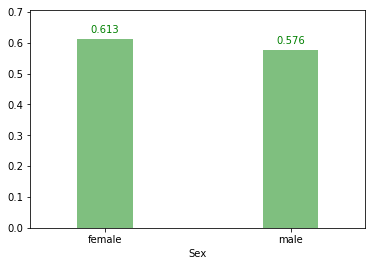

In [521]:
y = children_sex_survivalDistr['proption_survived']

for i, v in enumerate(y):
    plt.text(i, v + .02, str(v), color='Green', ha='center')

children_sex_survivalDistr['proption_survived'].plot.bar(color='g',alpha=0.5, width=0.3, rot=0)

ymax = max(children_sex_survivalDistr['proption_survived'])
plt.ylim(0, ymax * 1.15)
plt.show()